# Hands-on 01: Uso de modelos de propagação para análises sistêmicas

# Parte 02: Modelagem do Sombreamento

### Objetivos
As metas desse tutorial são ajudar o usuário na:
- Análise visual de potência recebida com sobreamento;
- Implementação do sombreamento correlacionado.


## Prática 01: Sobreamento descorrelacionado

Vamos escrever um código para criação do mapa de cobertura (REM) das 7 (sete) estações rádio base (ERBs), como ilustrado na figura a seguir.


![fig_hex](../FIGS/HD_01_MATLAB/fig_hex.png)


A modelagem tem as seguintes características:

- Grid com células hexagonais;
- ERBs macrocelulares com altura de 30 m;
- Estações móveis com altura média de 1,8 m;
- O raio de cada hexágono é um parâmetro ajustável denominado dR;
- As dimensões do grid celular com as 7 ERBs é 5dR x 6 $\sqrt{\frac{3}{4}}$ dR;
- Para fins de definição da Outage (falha da conexão por falta de potência), a sensibilidade do receptor é considerada igual a -104 dBm ([fonte](http://www.comlab.hut.fi/opetus/260/1v153.pdf));
- A EIRP (Effective Isotropic Radiated Power) é 57 dBm ([Discussão interessante sobre $P_{TX}$ e EIRP](https://under-linux.org/entry.php?b=1384)). Esse valor é compatível com receptores do GSM ([fonte](https://pt.slideshare.net/naveenjakhar12/gsm-link-budget));
- Somente a perda de percurso é considerada como manifestação de canal. Assim, a potência recebida será calculada com o modelo de Okumura-Hata para cidades urbanas grandes;
- A frequência da portadora é um parâmetro ajustável denominado dFc;
- Para evitar problema numéricos (divisão por zero ou logaritmo de zero), vamos modelar um raio de segurança. Para efeito de cálculo da potência recebida, todos os pontos menores que uma distância denominada dRMin, terão potência recebida igual aquela calculada usando dRMin como distância;
- **Sombreamento independente em cada ponto de medição, não importando a distância entre eles.**

A ideia é calcular a potência recebida em dBm para pontos equidistantes em toda a ára de cobertura. A distância entre os pontos de medição foi definida como o próximo valor inteiro maior que $\frac{dR}{20}$. Esse valor pode ser ajustado para melhor visualizar os REMs. 

**Passo 01:** Crie uma função chamada **fDrawSector.m** com o segunte código. Ela servirá para desenhar um hexágono de centro e raio especificados como parâmetro. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [1]:
%%file fDrawSector.m
function fDrawSector(dR,dCenter)
vtHex=zeros(1,0);
for ie=1:6
    vtHex=[vtHex dR*(cos((ie-1)*pi/3)+j*sin((ie-1)*pi/3))];
end
vtHex=vtHex+dCenter;
vtHexp=[vtHex vtHex(1)];
plot(vtHexp,'k');

Created file '/home/labsim/EEC1714/fDrawSector.m'.


**Passo 02:** Para testar a função, vamos criar um hexágono centrado no ponto (100,50) e com raio 100. Para isso execute o seguinte comando no Matlab (você precisa colocar o arquivo **fDrawSector.m** na pasta de trabalho do Matlab).   

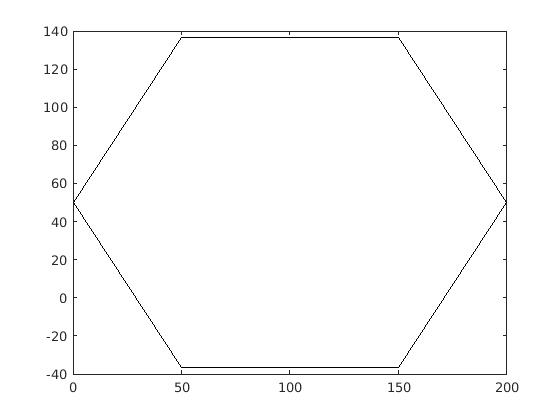

In [2]:
fDrawSector(100,100+50*i)

**Passo 03:** Crie uma função chamada **fDrawDeploy.m** com o segunte código. Ela servirá para desenhar o grid celular. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [3]:
%%file fDrawDeploy.m
function fDrawDeploy(dR,vtBs)
% Desenha setores hexagonais
hold on;
for iBsD = 1 : length(vtBs)
    fDrawSector(dR,vtBs(iBsD));
end
% Plot BSs
plot(vtBs,'sk'); axis equal;
end

Created file '/home/labsim/EEC1714/fDrawDeploy.m'.


**Passo 04:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson2_P2_1.m**). Nesse código, vamos criar um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.

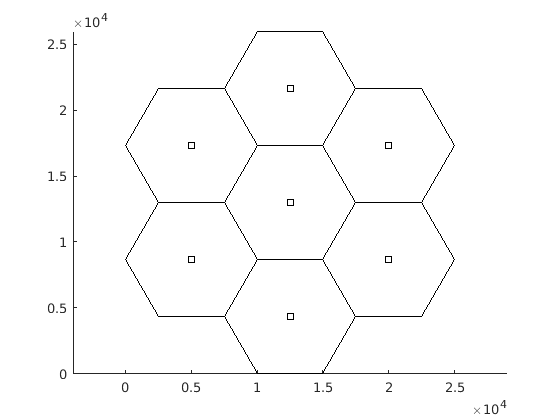

In [4]:
dR = 5e3; % Raio do Hexágono
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)

% Desenha setores hexagonais
fDrawDeploy(dR,vtBs)
axis equal;

## Prática 02: Cálculo e plot da potência recebida sem e com shadowing

Vamos escrever um código para o cálculo da potência recebida nos pontos de medição do REM de cada ERB, e também considerando a composição das 7 ERBs. Como especificado no hands-on, precisamos considerar que a potência recebida de cada ponto de medição é a maior potência recebida em relação às 7 ERBs.

**Passo 01:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson2_p21.m**). Nesse código, vamos:

- Criar sete matrizes de distâncias relativas de cada ponto de medição e para cada ERB (matrizes **mtDistEachBs**). Aplicaremos o raio de segurança a essas distâncias;
- Com as distâncias, usaremos o modelo de Okumura-Hata para calcular a perda de percurso (matrizes **mtPldB**);
- Sortearemos baseado em uma distribiução Lognormal amostras independentes do Sombreamento para cada ponto de medição (matrizes **mtShadowing**);
- Com as matrizes de EIRP, da perda de percurso e do sombreamento, calcularemos a potência recebida de cada ERB em cada ponto de medição. Para cada ERB montaremos a matriz **mtPowerEachBSdBm**;
- Montaremos uma única matriz **mtPowerFinaldBm** com a maior potência recebida em cada ponto de medição;
- Plotaremos o REM de cada ERB e da composição das 7 ERBs.

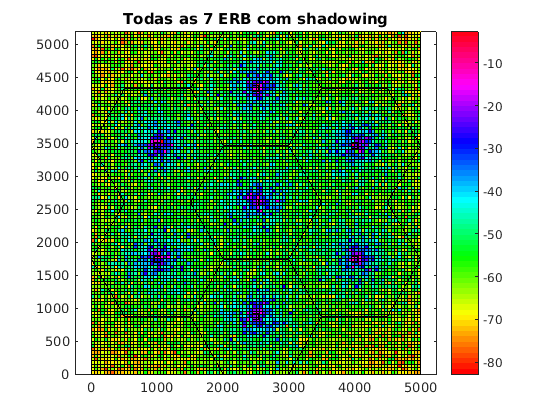

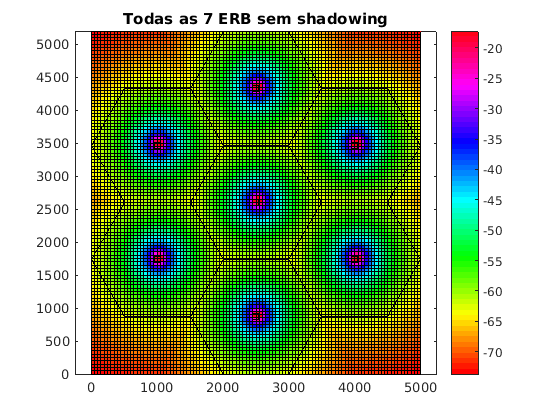

In [7]:
% Entrada de parâmetros
dR = 1e3;                                                  % Raio do Hexágono
dFc = 800;                                                 % Frequência da portadora
dSigmaShad = 8;                                            % Desvio padrão do sombreamento lognormal
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dPasso = ceil(dR/20);                                      % Resolução do grid: distância entre pontos de medição
dRMin = dPasso;                                            % Raio de segurança
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
dPtdBm = 57;                                               % EIRP (incluindo ganho e perdas) (https://pt.slideshare.net/naveenjakhar12/gsm-link-budget)
dPtLinear = 10^(dPtdBm/10)*1e-3;                           % EIRP em escala linear
dHMob = 5;                                                 % Altura do receptor
dHBs = 30;                                                 % Altura do transmissor
dAhm = 3.2*(log10(11.75*dHMob)).^2 - 4.97;                 % Modelo Okumura-Hata: Cidade grande e fc  >= 400MHz
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimY+mod(dDimY,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimX+mod(dDimX,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
% Iniciação da Matriz de com a pontência de recebida máxima em cada ponto
% medido. Essa potência é a maior entre as 7 ERBs.
mtPowerFinaldBm = -inf*ones(size(mtPosy));
mtPowerFinalShaddBm = -inf*ones(size(mtPosy));
% Calcular O REM de cada ERB e aculumar a maior potência em cada ponto de medição
for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
    % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
    % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
    mtPosEachBS = (mtPosx + j*mtPosy)-(vtBs(iBsD));
    mtDistEachBs = abs(mtPosEachBS);              % Distância entre cada ponto de medição e a sua ERB
    mtDistEachBs(mtDistEachBs < dRMin) = dRMin;             % Implementação do raio de segurança
    % Okumura-Hata (cidade urbana) - dB
    mtPldB = 69.55 + 26.16*log10(dFc) + (44.9 - 6.55*log10(dHBs))*log10(mtDistEachBs/1e3) - 13.82*log10(dHBs) - dAhm;
    % Shadowing independente em cada ponto
    mtShadowing = dSigmaShad*randn(size(mtPosy));
    % Potências recebidas em cada ponto de medição sem shadowing
    mtPowerEachBSdBm = dPtdBm - mtPldB;           
    % Potências recebidas em cada ponto de medição com shadowing
    mtPowerEachBSShaddBm = dPtdBm - mtPldB + mtShadowing;           
    % Cálulo da maior potência em cada ponto de medição sem shadowing
    mtPowerFinaldBm = max(mtPowerFinaldBm,mtPowerEachBSdBm);
    % Cálulo da maior potência em cada ponto de medição com shadowing
    mtPowerFinalShaddBm = max(mtPowerFinalShaddBm,mtPowerEachBSShaddBm);
end
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinaldBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB sem shadowing']);
%
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinalShaddBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB com shadowing']);

**A execução do código resulta em:**
1. Dois mapas REMs mostrando o grid celular e a potência recebida nos pontos de medição para as 7 ERBS;
2. Foi utilizado um colormap diferente da primeria parte do hands-on para diferenciar melhor os níveis de potência e as diferentes cores que o representa;
2. A situação com e sem sombreamento estão identificadas no título de cada gráfico;
3. Note que a distribuição de potência deixa de ser uniforme e radial quando o sombreamento está presente.

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

## Sombreamento correlacionado

Medidas em vários ambientes de comunicação móveis têm mostrado que o desvanecimento de larga escala do canal de propagação rádio-móvel entre um usuário e as diversas ERBs da rede é correlacionado [fonte](https://ieeexplore.ieee.org/document/1105). O grau de correlação não depende somente da separação entre as estações-bases, mas também da configuração dos espalhadores em volta do usuário móvel. 
    
A equação a seguir propõe um modelo para o sombreamento correlacionado, no qual o sombreamento entre um usuário
$i$ (ou um ponto de medição $i$) e uma ERB $j$ é composto de duas parcelas separadas: (i) Uma componente do ambiente; (ii) outra componente que depende do caminho entre receptor e transmissor (ERB e ponto de medição). 

\begin{equation}
    X_{\sigma _{i,j} }  = \sqrt \rho  X_{ST_i }  + \sqrt {1 - \rho }
    X_{MBP_{i,j} }
\end{equation}

sendo $X_{ST_i }$ a componente de sombreamento do ambiente, e $X_{MBP_{i,j} }$ a componente de sombreamento
dependente do caminho entre receptor e transmissor. A variável $\rho$ é o coeficiente de correlação do sombreamento entre ERB. Quando $\rho$ = 1, não existe correlação do sombreamento entre diferentes ERBs (o sombreamento de cada ERB é independente). Por outro lado, quando $\rho$ = 0, o sombreamento é igual para um ponto do espçao e qualquer ERB do sistema.

As contribuições da **componente do ambiente** são condicionadas somente à posição do usuário (ou ponto de medição), enquanto que  as **contribuições da componente dependente
do caminho entre receptor e transmissor** são dependentes tanto da posição dos usuários (ponto de medição), como da ERB em que ele está conectado.


Para estabelecer o modelo em duas dimensões faz-se necessário gerar um regra de correlação espacial entre as amostras de sombreamento utilizadas na equação acima. Nesse modelo, a área de cobertura é mapeada em grades quadradas, e cada ponto de intersecção dos quadrados (pontos de grade) tem amostras de sombreamento independentes. A figura a seguir ilustra essa modelagem.


![fig_shadcorr_mod](../FIGS/HD_01_MATLAB/fig_shadcorr_mod_300.png)

Assim, vamos construir um mapa 2D de amostras independentes de sombreamento para cada ERB. Cada mapa cobre toda área de cobertura simulada e dele é extraída a componente de sombreamento dependente do caminho entre receptor e transmissor ($X_{MBP_{i,j} }$). 

Para obter as amostras de sombreamento referente à componente do ambiente, um
mapa independente adicional é construído. Esse mapa é compartilhado por todos os usuários do sistema, e dele é obtido a
amostra $X_{ST_i }$ para cada usuário (ou ponto de medição) em questão.

As amostras de sombreamento para pontos de medição entre **pontos de grade** são correlacionadas com as amostras de sombreamento dos quatro pontos de grade mais próximos e calculadas por meio de uma interpolação linear. 

Por exemplo, a amostra de sombreamento para o usuário ilustrado na figura a seguir, em relação à uma
ERB qualquer, é mostrada na equação a seguir ([fonte](https://vtechworks.lib.vt.edu/handle/10919/29051)).

![fig_shadcorr_mod_zoom_300](../FIGS/HD_01_MATLAB/fig_shadcorr_mod_zoom_300.png)

\begin{equation}
    Xu = \left( {1 - Y} \right)\left[ {X_A \left( {1 - X} \right) +
    X_B \left( X \right)} \right] + \left( Y \right)\left[ {X_C \left(
    {1 - X} \right) + X_D \left( X \right)} \right]
\end{equation}

sendo $X_{A}$, $X_{B}$, $X_{C}$ e $X_{D}$ as amostras de sombreamento dos quatro pontos mais próximos do usuário (ponto de medição) em questão; $X$ e $Y$ são as distâncias horizontal e vertical entre o usuário (ponto de medição) e o ponto A, respectivamente. $X$ e $Y$ são normalizadas pela distância de descorrelação, assumindo valores entre 0 e 1. A distância de descorrelação $d_{dec}$ é a separação mostrada nas figuras anteriores, que é medida como a menor distância entre dois pontos de grade. Essa distância representa a separação física na qual duas amostras de sombreamento podem ser consideradas independentes.

Como as amostras de sombreamento têm distribuição LogNormal, as seguintes propriedades são válidas:

\begin{equation}
    Se\quad Z = \alpha A + \beta B,\quad ent{\tilde a}o \quad \sigma _Z^{2}  = \alpha^{2}\sigma _A^{2}  + \beta^{2}\sigma _B^{2},
\end{equation}

com $\alpha$ e $\beta$ constantes, $A$ e $B$ variáveis aleatórias com distribuição Gaussiana.

Essa relação é usada para calcular o desvio padrão da amostra ($X_{u}$) em um ponto $u$, como ilustrada no carrinho amarelo da figura, obtendo a equação:

\begin{equation}
    \sigma _{X_u }  = \sigma _X \sqrt {\left( {1 - 2Y + 2Y^2 }
    \right)\left( {1 - 2X + 2X^2 } \right)},
\end{equation}

sendo $\sigma_X$, o desvio padrão planejado para o sombreamento (o desvio padrão de cada ponto de grade), e $\sigma_{X_u}$, o desvio padrão calculado no ponto $u$. 

Nota-se que esse valor do desvio padrão no ponto $u$ é diferente que o especificado para cada ponto de grade individual, ou seja, o desvio padrão do sombreamento planejado. Portanto, a equação a seguir pode resolver esse problema.

\begin{equation}
    X'u = \frac{{Xu}}{{\sqrt {\left( {1 - 2X + 2X^2 } \right)\left( {1
    - 2Y + 2Y^2 } \right)} }}
\end{equation}

A figura a seguir ilustra um dos mapas de amostras de sombreamento para uma ERB arbitrária, construído por meio das equações acima. Construir mapas como esses e intergrá-los no cálculo do sombreamento correlacionado é o objetivo desse hands-on.

![figmapashadow](../FIGS/HD_01_MATLAB/figmapashadow.png)

Esse modelo é mais realista que considerar amostras totalmente descorrelacionadas de sombreamento, representando com mais fidelidade o que acontece com a atenuação do sinal de RF.

## Prática 03: Construção dos mapas de sombreamento correlacionado

Vamos escrever um código para construir um mapa de sombreamento correlacionado, incluindo a visualização espacial da distribuição dos pontos de medição. 

**Passo 01:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson2_p31.m**). Nesse código, vamos:

- Criar e plotar o grid com os pontos de grade do sombreamento correlacionado de acordo com uma distância de correlação qualquer;
- Criar uma regra para achar os quatro pontos de grade mais pŕoximos de um dado ponto de medição;
- Plotar os quatro pontos de grade mais pŕoximos de um dado ponto de medição.

X = 0.54 e Y = 0.54


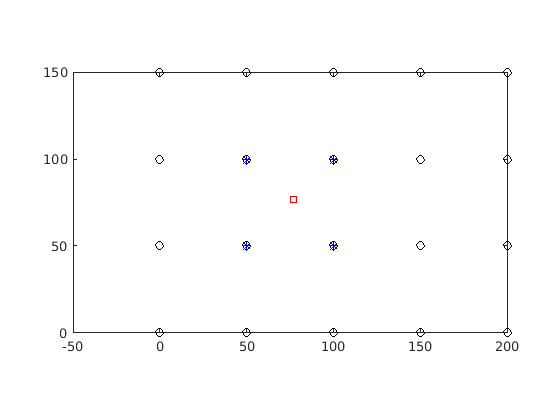

In [1]:
close all;clear all;clc;
% Entrada de parâmetros
dR = 200;                                                  % Raio do Hexágono
dShad = 50;                                                % Distância de descorrelação do shadowing
dPasso = 7;                                                % Distância entre pontos de medição
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dDimXOri = 5*dR;                                              % Dimensão X do grid
dDimYOri = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimYOri+mod(dDimYOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimXOri+mod(dDimXOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
mtPontosMedicao = mtPosx + j*mtPosy;
%
% Ponto de medição alvo (vamos localiza-lo no novo grid e plotar os quatro pontos que o circundam) - escolhido ao acaso
dshadPoint = mtPontosMedicao(12,12);
%
% Matriz de pontos equidistantes de dShad em dShad
dDimYS = ceil(dDimYOri+mod(dDimYOri,dShad));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimXS = ceil(dDimXOri+mod(dDimXOri,dShad)); 
[mtPosxShad,mtPosyShad] = meshgrid(0:dShad:dDimXS, 0:dShad:dDimYS);
mtPosShad = mtPosxShad+j*mtPosyShad;
%
% Achar a posição do ponto de medição na matriz de shadowing correlacionado
dXIndexP1 = real(dshadPoint)/dShad;
dYIndexP1 = imag(dshadPoint)/dShad;
%
% Cálculo dos demais pontos depende de:
%   (i) se o ponto de medição é um ponto de shadowing descorrelacionado
%   (i) se o ponto está na borda lateral direita do grid e no canto superior do grid;
%   (ii) se o ponto está na borda lateral direita do grid;
%   (iii) se o ponto está na borda superior do grid;
%   (iv)  se o ponto está no meio do grid.
if (mod(dXIndexP1,1) == 0 && mod(dYIndexP1,1) == 0)
    % O ponto de medição é um ponto de grade
    dXIndexP1 = floor(dXIndexP1)+1;
    dYIndexP1 = floor(dYIndexP1)+1;
    plot(complex(mtPosShad(dYIndexP1,dXIndexP1)),'g*');
    disp('O ponto de medição é um ponto de grade');
else
    % Índice na matriz do primeiro ponto próximo
    dXIndexP1 = floor(dXIndexP1)+1;
    dYIndexP1 = floor(dYIndexP1)+1;
    if (dXIndexP1 == size(mtPosyShad,2)  && dYIndexP1 == size(mtPosyShad,1) )
        % Ponto de medição está na borda da lateral direta do grid
        % e no canto superior
        % P2 - P1
        % |    |
        % P4 - P3
        %
        dXIndexP2 = dXIndexP1-1;
        dYIndexP2 = dYIndexP1;
        dXIndexP4 = dXIndexP1-1;
        dYIndexP4 = dYIndexP1-1;
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1-1;
        %
    elseif (dXIndexP1 == size(mtPosyShad,2))
        % Ponto de medição está na borda da lateral direta do grid
        % P4 - P3
        % |    |
        % P2 - P1
        %
        dXIndexP2 = dXIndexP1-1;
        dYIndexP2 = dYIndexP1;
        dXIndexP4 = dXIndexP1-1;
        dYIndexP4 = dYIndexP1+1;
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1+1;
    elseif (dYIndexP1 == size(mtPosyShad,1))
        % Ponto de medição está na borda superior do grid
        % P1 - P2
        % |    |
        % P3 - P4
        %
        dXIndexP2 = dXIndexP1+1;
        dYIndexP2 = dYIndexP1;
        %
        dXIndexP4 = dXIndexP1+1;
        dYIndexP4 = dYIndexP1-1;
        %
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1-1;
        %
    else
        % P4 - P3
        % |    |
        % P1 - P2
        %
        %
        dXIndexP2 = dXIndexP1+1;
        dYIndexP2 = dYIndexP1;
        %
        dXIndexP4 = dXIndexP1+1;
        dYIndexP4 = dYIndexP1+1;
        %
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1+1;
    end
    %
    % Plot dos pontos de grade
    plot(complex(mtPosShad),'ko')
    hold on;
    %
    % Plot do ponto de medição (quadrado vermelho)
    plot(complex(dshadPoint),'sr')
    %
    % Plot dos quadtro pontos de grade que circundam o ponto de medição
    mt4Poitns = complex([mtPosShad(dYIndexP1,dXIndexP1)...
        mtPosShad(dYIndexP2,dXIndexP2)...
        mtPosShad(dYIndexP3,dXIndexP3) ...
        mtPosShad(dYIndexP4,dXIndexP4)]);
    plot(mt4Poitns,'b*');
    axis equal;
    %
    % Zoom nos pontos próximos ao ponto investigado
    axis([-2*dShad+real(mtPosShad(dYIndexP3,dXIndexP3))...
        2*dShad+real(mtPosShad(dYIndexP4,dXIndexP4))...
        -2*dShad+imag(mtPosShad(dYIndexP3,dXIndexP3))...
        2*dShad+imag(mtPosShad(dYIndexP1,dXIndexP1))]);
    %
end
% Distâncias para regressão linear
dDistX = (mod(real(dshadPoint),dShad))/dShad;
dDistY = (mod(imag(dshadPoint),dShad))/dShad;

disp(['X = ' num2str(dDistX) ' e Y = ' num2str(dDistY)])


**A execução do código resulta em:**
1. Um gráfico mostrando: 
 - O ponto de medição como um quadrado vermelho; 
 - Os quatros pontos de grade que circundam os ponto de medição como asteriscos azuis; 
2. Esse código pode ser usado para verificar se os pontos de grade estão sendo identificados corretamente. Execute o código mudando a linha **dshadPoint = mtPontosMedicao(12,12)** para:
 - **dshadPoint = mtPontosMedicao(1,1)** 
 - **dshadPoint = mtPontosMedicao(1,end)** 
 - **dshadPoint = mtPontosMedicao(end,1)** 
 - **dshadPoint = mtPontosMedicao(end,end)** 


** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

**Passo 02:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson2_p32.m**). Nesse código, vamos:

- Sortear os pontos de sombreamento para os pontos de grade. A variável **dSigmaShad** define o desvio padrão do sombreamento lognormal criado;
- Coletar amostras de sombreamento dos quatro pontos de grade mais pŕoximos de um dado ponto de medição (ou o valor da amostra independente, caso o ponto de medição coincida com um ponto de grade);
- Calcular sobreamento via regressão linear.

X = 0.54 e Y = 0.54
O Sombreamento é 6.5319 dB


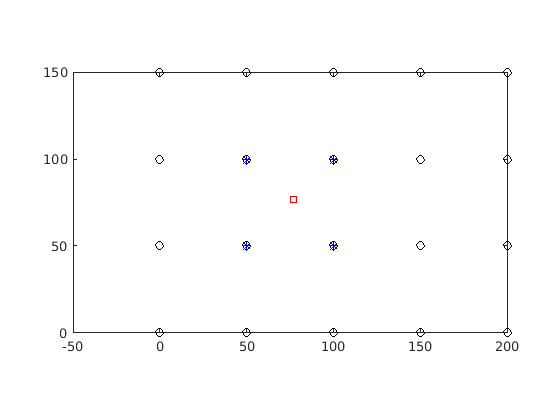

In [2]:
close all;clear all;clc;
% Entrada de parâmetros
dR = 200;                                                  % Raio do Hexágono
dShad = 50;                                                % Distância de descorrelação do shadowing
dPasso = 7;                                                % Distância entre pontos de medição
dSigmaShad = 8;                                            % Desvio padrão do sombreamento lognormal
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dDimXOri = 5*dR;                                              % Dimensão X do grid
dDimYOri = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimYOri+mod(dDimYOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimXOri+mod(dDimXOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
mtPontosMedicao = mtPosx + j*mtPosy;
%
% Ponto de medição alvo (vamos localiza-lo no novo grid e plotar os quatro pontos que o circundam) - escolhido ao acaso
dshadPoint = mtPontosMedicao(12,12);
%
% Matriz de pontos equidistantes de dShad em dShad
dDimYS = ceil(dDimYOri+mod(dDimYOri,dShad));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimXS = ceil(dDimXOri+mod(dDimXOri,dShad)); 
[mtPosxShad,mtPosyShad] = meshgrid(0:dShad:dDimXS, 0:dShad:dDimYS);
mtPosShad = mtPosxShad+j*mtPosyShad;
% Amostras de sombremento para os pontos de grade
mtShadowingSamples = dSigmaShad*randn(size(mtPosyShad));
%
% Achar a posição do ponto de medição na matriz de shadowing correlacionado
dXIndexP1 = real(dshadPoint)/dShad;
dYIndexP1 = imag(dshadPoint)/dShad;
%
% Cálculo dos demais pontos depende de:
%   (i) se o ponto de medição é um ponto de shadowing descorrelacionado
%   (i) se o ponto está na borda lateral direita do grid e no canto superior do grid;
%   (ii) se o ponto está na borda lateral direita do grid;
%   (iii) se o ponto está na borda superior do grid;
%   (iv)  se o ponto está no meio do grid.
if (mod(dXIndexP1,1) == 0 && mod(dYIndexP1,1) == 0)
    % O ponto de medição é um ponto de grade
    dXIndexP1 = floor(dXIndexP1)+1;
    dYIndexP1 = floor(dYIndexP1)+1;
    plot(complex(mtPosShad(dYIndexP1,dXIndexP1)),'g*');
    disp('O ponto de medição é um ponto de grade');
    % Amostra de sombreamento
    dShadowingC = mtShadowingSamples(dYIndexP1,dXIndexP1);
else
    % Índice na matriz do primeiro ponto próximo
    dXIndexP1 = floor(dXIndexP1)+1;
    dYIndexP1 = floor(dYIndexP1)+1;
    if (dXIndexP1 == size(mtPosyShad,2)  && dYIndexP1 == size(mtPosyShad,1) )
        % Ponto de medição está na borda da lateral direta do grid
        % e no canto superior
        % P2 - P1
        % |    |
        % P4 - P3
        %
        dXIndexP2 = dXIndexP1-1;
        dYIndexP2 = dYIndexP1;
        dXIndexP4 = dXIndexP1-1;
        dYIndexP4 = dYIndexP1-1;
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1-1;
        %
    elseif (dXIndexP1 == size(mtPosyShad,2))
        % Ponto de medição está na borda da lateral direta do grid
        % P4 - P3
        % |    |
        % P2 - P1
        %
        dXIndexP2 = dXIndexP1-1;
        dYIndexP2 = dYIndexP1;
        dXIndexP4 = dXIndexP1-1;
        dYIndexP4 = dYIndexP1+1;
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1+1;
    elseif (dYIndexP1 == size(mtPosyShad,1))
        % Ponto de medição está na borda superior do grid
        % P1 - P2
        % |    |
        % P3 - P4
        %
        dXIndexP2 = dXIndexP1+1;
        dYIndexP2 = dYIndexP1;
        %
        dXIndexP4 = dXIndexP1+1;
        dYIndexP4 = dYIndexP1-1;
        %
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1-1;
        %
    else
        % P4 - P3
        % |    |
        % P1 - P2
        %
        %
        dXIndexP2 = dXIndexP1+1;
        dYIndexP2 = dYIndexP1;
        %
        dXIndexP4 = dXIndexP1+1;
        dYIndexP4 = dYIndexP1+1;
        %
        dXIndexP3 = dXIndexP1;
        dYIndexP3 = dYIndexP1+1;
    end
    %
    % Plot dos pontos de grade
    plot(complex(mtPosShad),'ko')
    hold on;
    %
    % Plot do ponto de medição (quadrado vermelho)
    plot(complex(dshadPoint),'sr')
    %
    % Plot dos quadtro pontos de grade que circundam o ponto de medição
    mt4Poitns = complex([mtPosShad(dYIndexP1,dXIndexP1)...
        mtPosShad(dYIndexP2,dXIndexP2)...
        mtPosShad(dYIndexP3,dXIndexP3) ...
        mtPosShad(dYIndexP4,dXIndexP4)]);
    plot(mt4Poitns,'b*');
    axis equal;
    %
    % Zoom nos pontos próximos ao ponto investigado
    axis([-2*dShad+real(mtPosShad(dYIndexP3,dXIndexP3))...
        2*dShad+real(mtPosShad(dYIndexP4,dXIndexP4))...
        -2*dShad+imag(mtPosShad(dYIndexP3,dXIndexP3))...
        2*dShad+imag(mtPosShad(dYIndexP1,dXIndexP1))]);
    %
    % Distâncias para regressão linear
    dDistX = (mod(real(dshadPoint),dShad))/dShad;
    dDistY = (mod(imag(dshadPoint),dShad))/dShad;
    disp(['X = ' num2str(dDistX) ' e Y = ' num2str(dDistY)])
    % Ajuste do desvio padrão devido a regressão linear
    dStdNormFactor = sqrt( (1 - 2 * dDistY + 2 * (dDistY^2) )*(1 - 2 * dDistX + 2 * (dDistX^2) ) );
    %
    % Amostras do sombreamento para os quatro pontos de grade
    dSample1 = mtShadowingSamples(dYIndexP1,dXIndexP1);
    dSample2 = mtShadowingSamples(dYIndexP2,dXIndexP2);
    dSample3 = mtShadowingSamples(dYIndexP3,dXIndexP3);
    dSample4 = mtShadowingSamples(dYIndexP4,dXIndexP4);
    dShadowingC = ( (1-dDistY)*[dSample1*(1-dDistX) + dSample2*(dDistX)] +...
        (dDistY)*[dSample3*(1-dDistX) + dSample4*(dDistX)])/dStdNormFactor;
end
disp(['O Sombreamento é ' num2str(dShadowingC) ' dB'])


**Passo 03:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson2_p33.m**). Nesse código, vamos:

- Calcular o sobreamento via regressão linear para todos os pontos de medição;
- Remover gráfico de pontos e display de mensagens;
- Mostrar a atenuação por sombreamento em um gráfico 3D. 

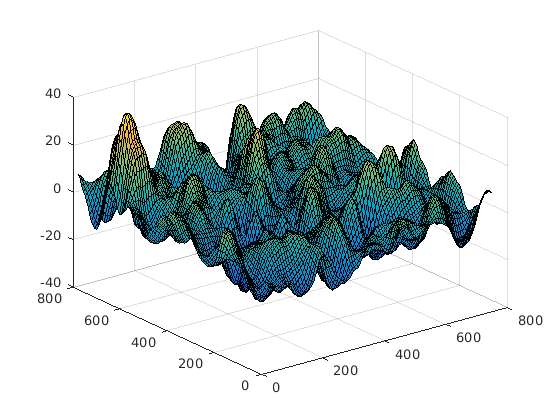

In [6]:
close all;clear all;clc;
% Entrada de parâmetros
dR = 150;                                                  % Raio do Hexágono
dShad = 50;                                                % Distância de descorrelação do shadowing
dPasso = 7;                                                % Distância entre pontos de medição
dSigmaShad = 8;                                            % Desvio padrão do sombreamento lognormal
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dDimXOri = 5*dR;                                              % Dimensão X do grid
dDimYOri = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimYOri+mod(dDimYOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimXOri+mod(dDimXOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
mtPontosMedicao = mtPosx + j*mtPosy;
%
% Matriz de pontos equidistantes de dShad em dShad
dDimYS = ceil(dDimYOri+mod(dDimYOri,dShad));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimXS = ceil(dDimXOri+mod(dDimXOri,dShad));
[mtPosxShad,mtPosyShad] = meshgrid(0:dShad:dDimXS, 0:dShad:dDimYS);
mtPosShad = mtPosxShad+j*mtPosyShad;
% Amostras de sombremento para os pontos de grade
mtShadowingSamples = dSigmaShad*randn(size(mtPosyShad));

[dSizel, dSizec] = size(mtPontosMedicao);

for il = 1: dSizel
    for ic = 1: dSizec
        %
        % Ponto de medição alvo (vamos localiza-lo no novo grid e plotar os quatro pontos que o circundam) - escolhido ao acaso
        dshadPoint = mtPontosMedicao(il,ic);
        %
        % Achar a posição do ponto de medição na matriz de shadowing correlacionado
        dXIndexP1 = real(dshadPoint)/dShad;
        dYIndexP1 = imag(dshadPoint)/dShad;
        %
        % Cálculo dos demais pontos depende de:
        %   (i) se o ponto de medição é um ponto de shadowing descorrelacionado
        %   (i) se o ponto está na borda lateral direita do grid e no canto superior do grid;
        %   (ii) se o ponto está na borda lateral direita do grid;
        %   (iii) se o ponto está na borda superior do grid;
        %   (iv)  se o ponto está no meio do grid.
        if (mod(dXIndexP1,1) == 0 && mod(dYIndexP1,1) == 0)
            % O ponto de medição é um ponto de grade
            dXIndexP1 = floor(dXIndexP1)+1;
            dYIndexP1 = floor(dYIndexP1)+1;
            plot(complex(mtPosShad(dYIndexP1,dXIndexP1)),'g*');
            % Amostra de sombreamento
            mtShadowingCorr(il,ic) = mtShadowingSamples(dYIndexP1,dXIndexP1);
        else
            % Índice na matriz do primeiro ponto próximo
            dXIndexP1 = floor(dXIndexP1)+1;
            dYIndexP1 = floor(dYIndexP1)+1;
            if (dXIndexP1 == size(mtPosyShad,2)  && dYIndexP1 == size(mtPosyShad,1) )
                % Ponto de medição está na borda da lateral direta do grid
                % e no canto superior
                % P2 - P1
                % |    |
                % P4 - P3
                %
                dXIndexP2 = dXIndexP1-1;
                dYIndexP2 = dYIndexP1;
                dXIndexP4 = dXIndexP1-1;
                dYIndexP4 = dYIndexP1-1;
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1-1;
                %
            elseif (dXIndexP1 == size(mtPosyShad,2))
                % Ponto de medição está na borda da lateral direta do grid
                % P4 - P3
                % |    |
                % P2 - P1
                %
                dXIndexP2 = dXIndexP1-1;
                dYIndexP2 = dYIndexP1;
                dXIndexP4 = dXIndexP1-1;
                dYIndexP4 = dYIndexP1+1;
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1+1;
            elseif (dYIndexP1 == size(mtPosyShad,1))
                % Ponto de medição está na borda superior do grid
                % P1 - P2
                % |    |
                % P3 - P4
                %
                dXIndexP2 = dXIndexP1+1;
                dYIndexP2 = dYIndexP1;
                %
                dXIndexP4 = dXIndexP1+1;
                dYIndexP4 = dYIndexP1-1;
                %
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1-1;
                %
            else
                % P4 - P3
                % |    |
                % P1 - P2
                %
                %
                dXIndexP2 = dXIndexP1+1;
                dYIndexP2 = dYIndexP1;
                %
                dXIndexP4 = dXIndexP1+1;
                dYIndexP4 = dYIndexP1+1;
                %
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1+1;
            end
            %
            % Distâncias para regressão linear
            dDistX = (mod(real(dshadPoint),dShad))/dShad;
            dDistY = (mod(imag(dshadPoint),dShad))/dShad;
            % Ajuste do desvio padrão devido a regressão linear
            dStdNormFactor = sqrt( (1 - 2 * dDistY + 2 * (dDistY^2) )*(1 - 2 * dDistX + 2 * (dDistX^2) ) );
            %
            % Amostras do sombreamento para os quatro pontos de grade
            dSample1 = mtShadowingSamples(dYIndexP1,dXIndexP1);
            dSample2 = mtShadowingSamples(dYIndexP2,dXIndexP2);
            dSample3 = mtShadowingSamples(dYIndexP3,dXIndexP3);
            dSample4 = mtShadowingSamples(dYIndexP4,dXIndexP4);
            mtShadowingCorr(il,ic) = ( (1-dDistY)*[dSample1*(1-dDistX) + dSample2*(dDistX)] +...
                (dDistY)*[dSample3*(1-dDistX) + dSample4*(dDistX)])/dStdNormFactor;
        end
    end
end
% Plot da superfície de atenuação devido ao sombreamento
surf(mtPosx,mtPosy,mtShadowingCorr)

Nota que o sombreamento tem comportamento mais suave e não muda bruscamente para pontos próximos.

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando uma IDE de sua preferência.**

## Prática 04: Cálculo e plot da potência recebida com sombreamento correlacionado

amos escrever um código para o cálculo da potência recebida nos pontos de medição do REM de cada ERB, e também considerando a composição das 7 ERBs. Como especificado no hands-on 01, precisamos considerar que a potência recebida de cada ponto de medição é a maior potência recebida em relação as 7 ERBs.

A ideia é calcular o REM para todo o grid, considerando três casos: (i) Somente path loss; (ii) Path loss e sombreamento descorrelacionado; e (iii) Path loss e sombreamento correlacionado. 

**Passo 01:** Crie uma função chamada **fDrawDeploy.m** com o segunte código. Ela servirá para desenhar o grid celular. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [10]:
%%file fDrawSector.m
function fDrawSector(dR,dCenter)
vtHex=zeros(1,0);
for ie=1:6
    vtHex=[vtHex dR*(cos((ie-1)*pi/3)+j*sin((ie-1)*pi/3))];
end
vtHex=vtHex+dCenter;
vtHexp=[vtHex vtHex(1)];
plot(vtHexp,'k');

Created file '/home/gppcom/2020_5/DCO1020_2020_5/fDrawSector.m'.


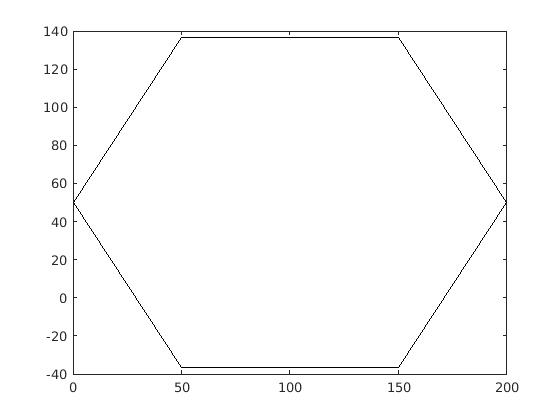

In [11]:
fDrawSector(100,100+50*i)

**Passo 02:** Crie uma função chamada **fDrawDeploy.m** com o segunte código. Ela servirá para desenhar o grid celular. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [5]:
%%file fDrawDeploy.m
function fDrawDeploy(dR,vtBs)
% Desenha setores hexagonais
hold on;
for iBsD = 1 : length(vtBs)
    fDrawSector(dR,vtBs(iBsD));
end
% Plot BSs
plot(vtBs,'sk'); axis equal;
end

Created file '/home/gppcom/2020_5/DCO1020_2020_5/fDrawDeploy.m'.


**Passo 03:** Agora vamos criar uma função chamada **fCorrShadowing** com uma versão modificada do código que estamos trabalhando até o momento. Essa função vai realizar as seguintes funcionalidades:
- Criar 8 mapas de atenuação de sombreamento (7 para as ERBs e 1 comum) e devolver um mapa do sombreameto de cada ponto de medição, considerando o valor do **dAlphaCorr** para controlar a correlação do sombreamento entre ERBs;

Crie um arquivo  **fCorrShadowing.m** com seguinte código. **Atenção:** você precisa colocar o arquivo **fCorrShadowing.m** na pasta de trabalho do Matlab.

In [2]:
%%file fCorrShadowing.m
function mtShadowingCorr = fCorrShadowing(mtPoints,dShad,dAlphaCorr,dSigmaShad,dDimXOri,dDimYOri)
% INPUTS:
%   mtPoints: Matriz de números complexos com os pontos de medição
%   dShad: Distância de descorrelação do shadowing
%   dSigmaShad: Desvio padrão do shadowing Lognormal
%   dAlphaCorr: Coeficiente de correlação do sombreamento entre ERBs
%   dDimXOri: Dimensão X do grid em metros
%   dDimYOri: Dimensão Y do grid em metros
%
% Matriz de pontos equidistantes de dShad em dShad
dDimYS = ceil(dDimYOri+mod(dDimYOri,dShad));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimXS = ceil(dDimXOri+mod(dDimXOri,dShad));
[mtPosxShad,mtPosyShad] = meshgrid(0:dShad:dDimXS, 0:dShad:dDimYS);
mtPosShad = mtPosxShad+j*mtPosyShad;
%
% Amostras de sombremento para os pontos de grade
% Matrizes com amostras de shadowing independentes
% 7 matrizes, uma cada cada ERB
% 1 matriz para o ambiente
for iMap = 1:8
    mtShadowingSamples(:,:,iMap) = dSigmaShad*randn(size(mtPosyShad));
end

[dSizel, dSizec] = size(mtPoints);
for il = 1: dSizel
    for ic = 1: dSizec
        %
        % Ponto de medição alvo (vamos localiza-lo no novo grid e plotar os quatro pontos que o circundam) - escolhido ao acaso
        dshadPoint = mtPoints(il,ic);
        %
        % Achar a posição do ponto de medição na matriz de shadowing correlacionado
        dXIndexP1 = real(dshadPoint)/dShad;
        dYIndexP1 = imag(dshadPoint)/dShad;
        %
        % Cálculo dos demais pontos depende de:
        %   (i) se o ponto de medição é um ponto de shadowing descorrelacionado
        %   (i) se o ponto está na borda lateral direita do grid e no canto superior do grid;
        %   (ii) se o ponto está na borda lateral direita do grid;
        %   (iii) se o ponto está na borda superior do grid;
        %   (iv)  se o ponto está no meio do grid.
        if (mod(dXIndexP1,1) == 0 && mod(dYIndexP1,1) == 0)
            % O ponto de medição é um ponto de grade
            dXIndexP1 = floor(dXIndexP1)+1;
            dYIndexP1 = floor(dYIndexP1)+1;
            % Amostra de sombreamento do ambiente
            dShadowingC = mtShadowingSamples(dYIndexP1,dXIndexP1,8);
            % Amostra do sombreamento de cada ERB
            for iMap = 1:7
                dShadowingERB = mtShadowingSamples(dYIndexP1,dXIndexP1,iMap);
                mtShadowingCorr(il,ic,iMap) = sqrt(dAlphaCorr)*dShadowingC + sqrt(1-dAlphaCorr)*dShadowingERB;
            end
        else
            % Índice na matriz do primeiro ponto próximo
            dXIndexP1 = floor(dXIndexP1)+1;
            dYIndexP1 = floor(dYIndexP1)+1;
            if (dXIndexP1 == size(mtPosyShad,2)  && dYIndexP1 == size(mtPosyShad,1) )
                % Ponto de medição está na borda da lateral direta do grid
                % e no canto superior
                % P2 - P1
                % |    |
                % P4 - P3
                %
                dXIndexP2 = dXIndexP1-1;
                dYIndexP2 = dYIndexP1;
                dXIndexP4 = dXIndexP1-1;
                dYIndexP4 = dYIndexP1-1;
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1-1;
                %
            elseif (dXIndexP1 == size(mtPosyShad,2))
                % Ponto de medição está na borda da lateral direta do grid
                % P4 - P3
                % |    |
                % P2 - P1
                %
                dXIndexP2 = dXIndexP1-1;
                dYIndexP2 = dYIndexP1;
                dXIndexP4 = dXIndexP1-1;
                dYIndexP4 = dYIndexP1+1;
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1+1;
            elseif (dYIndexP1 == size(mtPosyShad,1))
                % Ponto de medição está na borda superior do grid
                % P1 - P2
                % |    |
                % P3 - P4
                %
                dXIndexP2 = dXIndexP1+1;
                dYIndexP2 = dYIndexP1;
                %
                dXIndexP4 = dXIndexP1+1;
                dYIndexP4 = dYIndexP1-1;
                %
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1-1;
                %
            else
                % P4 - P3
                % |    |
                % P1 - P2
                %
                %
                dXIndexP2 = dXIndexP1+1;
                dYIndexP2 = dYIndexP1;
                %
                dXIndexP4 = dXIndexP1+1;
                dYIndexP4 = dYIndexP1+1;
                %
                dXIndexP3 = dXIndexP1;
                dYIndexP3 = dYIndexP1+1;
            end
            %
            % Distâncias para regressão linear
            dDistX = (mod(real(dshadPoint),dShad))/dShad;
            dDistY = (mod(imag(dshadPoint),dShad))/dShad;
            % Ajuste do desvio padrão devido a regressão linear
            dStdNormFactor = sqrt( (1 - 2 * dDistY + 2 * (dDistY^2) )*(1 - 2 * dDistX + 2 * (dDistX^2) ) );
            %
            % Amostra do sombreamento do mapa comum
            dSample1 = mtShadowingSamples(dYIndexP1,dXIndexP1,8);
            dSample2 = mtShadowingSamples(dYIndexP2,dXIndexP2,8);
            dSample3 = mtShadowingSamples(dYIndexP3,dXIndexP3,8);
            dSample4 = mtShadowingSamples(dYIndexP4,dXIndexP4,8);
            dShadowingC = ( (1-dDistY)*[dSample1*(1-dDistX) + dSample2*(dDistX)] +...
                (dDistY)*[dSample3*(1-dDistX) + dSample4*(dDistX)])/dStdNormFactor;
            % Amostra do sombreamento de cada ERB
            for iMap = 1:7
                dSample1 = mtShadowingSamples(dYIndexP1,dXIndexP1,iMap);
                dSample2 = mtShadowingSamples(dYIndexP2,dXIndexP2,iMap);
                dSample3 = mtShadowingSamples(dYIndexP3,dXIndexP3,iMap);
                dSample4 = mtShadowingSamples(dYIndexP4,dXIndexP4,iMap);
                dShadowingERB = ( (1-dDistY)*[dSample1*(1-dDistX) + dSample2*(dDistX)] +...
                    (dDistY)*[dSample3*(1-dDistX) + dSample4*(dDistX)])/dStdNormFactor;
                mtShadowingCorr(il,ic,iMap) = sqrt(dAlphaCorr)*dShadowingC + sqrt(1-dAlphaCorr)*dShadowingERB;
            end
        end
    end
end
end

Created file '/home/gppcom/2020_5/DCO1020_2020_5/fCorrShadowing.m'.


**Passo 04:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson2_p41.m**). Nesse código, vamos:

- Criar 8 mapas de atenuação de sombreamento (7 para as ERBs e 1 comum);
- Incluir o parâmetro **dAlphaCorr** para controlar a correlação do sombreamento entre ERBs;
- Remover gráfico da atenuação por sombreamento em um gráfico 3D;
- Calcular REM para todo o grid, considerando três casos: (i) Somente path loss; (ii) Path loss e sombreamento descorrelacionado; e (iii) Path loss e sombreamento correlacionado. 

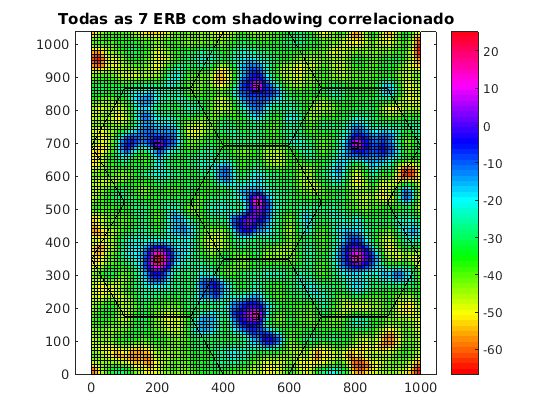

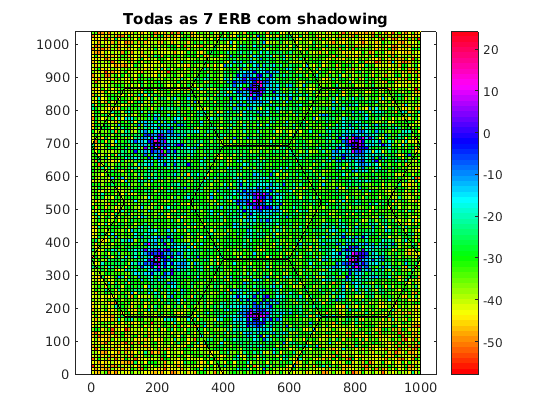

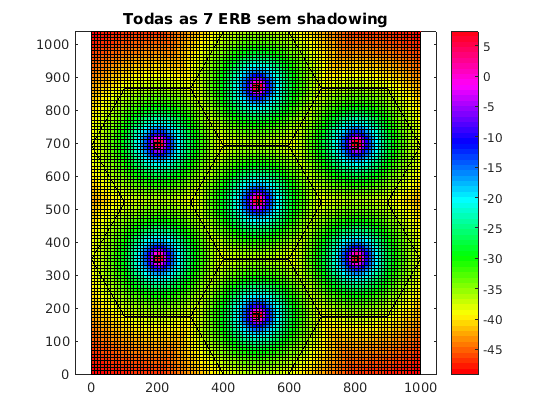

In [4]:
% Entrada de parâmetros
dR = 200;                                                  % Raio do Hexágono
dFc = 800;                                                 % Frequência da portadora
dShad = 50;                                                % Distância de descorrelação do shadowing
dSigmaShad = 8;                                            % Desvio padrão do sombreamento lognormal
dAlphaCorr = 0.5;                                          % Coeficiente de correlação do sombreamento entre ERBs (sombreamento correlacionado)
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
%dPasso = ceil(dR/10);                                     % Resolução do grid: distância entre pontos de medição
dPasso = 10;
dRMin = dPasso;                                            % Raio de segurança
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
%
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dDimXOri = 5*dR;                                           % Dimensão X do grid
dDimYOri = 6*sqrt(3/4)*dR;                                 % Dimensão Y do grid
dPtdBm = 57;                                               % EIRP (incluindo ganho e perdas) (https://pt.slideshare.net/naveenjakhar12/gsm-link-budget)
dPtLinear = 10^(dPtdBm/10)*1e-3;                           % EIRP em escala linear
dHMob = 5;                                                 % Altura do receptor
dHBs = 30;                                                 % Altura do transmissor
dAhm = 3.2*(log10(11.75*dHMob)).^2 - 4.97;                 % Modelo Okumura-Hata: Cidade grande e fc  >= 400MHz
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimXOri/2 + j*dDimYOri/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimYOri+mod(dDimYOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimXOri+mod(dDimXOri,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
mtPontosMedicao = mtPosx + j*mtPosy;
% Iniciação da Matriz de com a pontência de recebida máxima em cada ponto
% medido. Essa potência é a maior entre as 7 ERBs.
mtPowerFinaldBm = -inf*ones(size(mtPosy));
mtPowerFinalShaddBm = -inf*ones(size(mtPosy));
mtPowerFinalShadCorrdBm = -inf*ones(size(mtPosy));
%
% Calcula o sombreamento correlacionado
mtShadowingCorr = fCorrShadowing(mtPontosMedicao,dShad,dAlphaCorr,dSigmaShad,dDimXOri,dDimYOri);
%
% Calcular O REM de cada ERB e aculumar a maior potência em cada ponto de medição
for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
    % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
    % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
    mtPosEachBS = mtPontosMedicao-(vtBs(iBsD));
    mtDistEachBs = abs(mtPosEachBS);              % Distância entre cada ponto de medição e a sua ERB
    mtDistEachBs(mtDistEachBs < dRMin) = dRMin;             % Implementação do raio de segurança
    % Okumura-Hata (cidade urbana) - dB
    mtPldB = 69.55 + 26.16*log10(dFc) + (44.9 - 6.55*log10(dHBs))*log10(mtDistEachBs/1e3) - 13.82*log10(dHBs) - dAhm;
    % Shadowing independente em cada ponto
    mtShadowing = dSigmaShad*randn(size(mtPosy));
    % Potências recebidas em cada ponto de medição sem shadowing
    mtPowerEachBSdBm = dPtdBm - mtPldB;
    % Potências recebidas em cada ponto de medição com shadowing
    mtPowerEachBSShaddBm = dPtdBm - mtPldB + mtShadowing;
    % Potências recebidas em cada ponto de medição com shadowing
    % correlacionado
    mtPowerEachBSShadCorrdBm = dPtdBm - mtPldB + mtShadowingCorr(:,:,iBsD);
    % Cálulo da maior potência em cada ponto de medição sem shadowing
    mtPowerFinaldBm = max(mtPowerFinaldBm,mtPowerEachBSdBm);
    % Cálulo da maior potência em cada ponto de medição com shadowing
    mtPowerFinalShaddBm = max(mtPowerFinalShaddBm,mtPowerEachBSShaddBm);
    % Cálulo da maior potência em cada ponto de medição com shadowing
    mtPowerFinalShadCorrdBm = max(mtPowerFinalShadCorrdBm,mtPowerEachBSShadCorrdBm);
end
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinaldBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB sem shadowing']);
%
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinalShaddBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB com shadowing']);
%
% Plot da REM de todo o grid (composição das 7 ERBs) com shadowing
% correlacionado
figure;
pcolor(mtPosx,mtPosy,mtPowerFinalShadCorrdBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB com shadowing correlacionado']);

**A execução do código resulta em:**
1. Gráficos com o REM para todo o grid, considerando três casos: 

 - Somente path loss; 
 - Path loss e sombreamento descorrelacionado; 
 - Path loss e sombreamento correlacionado. 
 
Note que o caso com sombreamento correlacionado apresenta a distribiução mais uniforme dos níveis de potência, quando comparamos com o caso do sombreamento descorrelacionado. 

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

##  Entrega 3: Comprovação do fator de ajuste do desvio padrão do sombreamento correlacionado

Escreva um código para comprovar que o desvio padrão das amostras do sombreamento correlacionado tem o mesmo desvio padrão de entrada **dSigmaShad**. Comprovar que isso é verdade independente do valor de **dAlphaCorr**.

Verificar se as amostras **mtShadowingCorr** tem sombreamento com desvio padrão **dSigmaShad** para alguns valores de **dAlphaCorr**.

**Atenção:** Caso o valor não bate, tente modificar o código para corrigir o problema (a priori, ele não existe).


##  Entrega 4: Modelagem e avaliação da inclusão de microcélulas


Uma solução tecnológica para tratar problemas de cobertura é o uso de repetidores (microcélulas, picocélulas) com intuito de estender o alcance de uma estrutura macrocelular (torres altas e com alta potência). Considere o uso de microcélulas com as seguintes características:

  - Potência de transmissão: 0.1 W
  - Perda de percurso: PL = 55 + 38 $\cdot$ log$_{10}$(d)+ (24.5 + $\frac{1.5*f}{925}$)*log$_{10}$(f), com d em km e f em MHz;
   
Seu alvo é analisar 3 cenários:

  - (i) Sistema somente com perda de percurso (sem shadowing), f = 800 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  - (ii) Sistema somente com perda de percurso (sem shadowing), f = 1800 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  - (iii)Sistema somente com perda de percurso (sem shadowing), f = 2100 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  

Prepare um primeiro conjunto de resultados, ainda sem microcélulas, e com a potência da macrocélula igual a 21 dBm. Eles são:

 - REMs com somente de duas cores, identificando: (i) a área de Outage do mapa (cor 1); e (ii) área com potência maior que a mínima (cor 2). Fazer 3 REMs, uma para cada cenário. Analise esses gráficos e decida qual o melhor posicionamento da suas seis microcélulas. Inclua esses REMs no seu relatório. 
 
 - Discuta se as áreas de outage mudaram, e se essa mudança a fez escolher posicionamento diferentes para microcélulas, dependendo da frequência da portadora;

De posse do primeiro conjunto de resultados, posicione seis (somente seis) microcélulas nos pontos estratégicos escolhidos por você. Deve ficar claro no seu relatório a razão do posicionamento escolhido. 

O sistema não é multi-conectividade, i.e., a potência de um ponto NÃO é a SOMA da potência da melhor macrocélula com a microcélula. Assim, como um usuário está conectado ou a macrocélula ou a microcélula, ao final você terá somente uma matriz de potências recebidas.

A figura a seguir mostra um exemplo de posicionamento de seis microcélulas. Será que algumas dessas posições são realmente as mais aconselhadas para resolver o problema da Outage?

![fig_shadcorr_mod_zoom_300](../FIGS/HD_01_MATLAB/microcelulas.png)

Agora com as microcélulas inteligentemente posicionadas por você, faça um segundo conjutno de resultados com:

 - Os mesmos 3 REMs, mas agora com a inclusão das microcélulas (um REM para cada frequência da portadora). Compare os REMS com e sem microcélula para cada cenário;
 - Fazer um gráfico de barras (pode ser no Microsoft Excel, por exemplo) da outage com e sem microcélula para cada cenário.
 
 
Considere -90 dBm como potência mínima de operação, i.e., um usuário (ou ponto no grid) é bloqueado se sua potência recebida for menor que esse valor. Outra consideração importante é que os usuários estão conectados a melhor estação rádio base. Faça os mapas com resolução espacial de 50 m. Se necessário, essa resolução pode ser diminuída, para melhor visualização da cobertura das microcélulas.

Compare os resultados com a situação sem a microcélulas. Quais as principais observações e diferenças? inclua figuras e discussão no seu relatório.